## 0. Loading Packages

In [1]:
## Loading Modules

import sys, subprocess, os, time, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import font_manager
from matplotlib.font_manager import FontProperties
import matplotlib as mpl
from matplotlib_venn import venn3
import matplotlib.gridspec as gridspec
from collections import defaultdict
import re

mpl.rcParams['font.family']        = 'Arial'
mpl.rcParams['font.weight']        = 'bold'
mpl.rcParams['axes.titleweight']   = 'bold'
mpl.rcParams['axes.labelweight']   = 'bold'
# mpl.rcParams['xtick.labelsize']    = 20  # 필요시 글자 크기 조절
# mpl.rcParams['ytick.labelsize']    = 20

import seaborn as sns
from scipy.sparse import csr_matrix

from IPython.display import Image
from IPython.core.display import HTML

In [2]:
#### Session Information

print("=" * 50)
print("Start time :", time.ctime())
print("Sever :", subprocess.check_output("uname -a", shell=True, universal_newlines=True).split()[1])
print("Conda :", subprocess.check_output("conda env list", shell=True, universal_newlines=True))
print("Java :",subprocess.check_output("which java & java -version | sed -n 1p", shell = True, universal_newlines=True))
print("Python :",subprocess.check_output("which python & python --version | sed -n 1p", shell = True, universal_newlines=True))
print("R :",subprocess.check_output("which R & R --version | sed -n 1p", shell = True, universal_newlines=True))
print("Perl :", subprocess.check_output("which perl & perl -version | sed -n 2p", shell = True, universal_newlines=True))
print("=" * 50)

Start time : Sun Nov 30 14:23:24 2025
Sever : gmi-analysis02
Conda : # conda environments:
#
base                     /mnt/gmi-l1/_90.User_Data/hsp224/anaconda3
2023KOGO                 /mnt/gmi-l1/_90.User_Data/hsp224/anaconda3/envs/2023KOGO
ASCAT                    /mnt/gmi-l1/_90.User_Data/hsp224/anaconda3/envs/ASCAT
Absolute                 /mnt/gmi-l1/_90.User_Data/hsp224/anaconda3/envs/Absolute
Bacteria                 /mnt/gmi-l1/_90.User_Data/hsp224/anaconda3/envs/Bacteria
Bismark                  /mnt/gmi-l1/_90.User_Data/hsp224/anaconda3/envs/Bismark
CNV_25.03                /mnt/gmi-l1/_90.User_Data/hsp224/anaconda3/envs/CNV_25.03
CNVkit                   /mnt/gmi-l1/_90.User_Data/hsp224/anaconda3/envs/CNVkit
CTK                      /mnt/gmi-l1/_90.User_Data/hsp224/anaconda3/envs/CTK
CellChat_23.12           /mnt/gmi-l1/_90.User_Data/hsp224/anaconda3/envs/CellChat_23.12
CellRank_23.12           /mnt/gmi-l1/_90.User_Data/hsp224/anaconda3/envs/CellRank_23.12
Cellrank_25.05   

openjdk version "1.8.0_362"
OpenJDK Runtime Environment (build 1.8.0_362-b08)
OpenJDK 64-Bit Server VM (build 25.362-b08, mixed mode)


In [3]:
## Input Files
path1 = '/data2/Users/hsp224/Project/RNAmethylation/21.07.22_KRAS_newanti/Exomepeak2/50BP_trim/Trimmomatic/22.06.09_Final/'
# gtf = pd.read_csv('/data2/Users/hsp224/Reference/GDC/gencode.v22.annotation.gene.bed', sep = '\t', header = None, names = ['chr', 'start', 'end', 'gene'])
gtf = '/data2/Users/hsp224/Reference/GDC/gencode.v22.annotation.gtf'
sample = ['W1', 'W3', 'G12D', 'G12V']
os.getcwd()

'/data2/Users/hsp224/Project/RNAmethylation/25.05_Paper/Github'

## 1. Processing gtf file

In [4]:
def parse_gtf_attributes(attr_text):
    d = {}
    for k, v in re.findall(r'(\S+)\s+"([^"]+)"', attr_text):
        d[k] = v
    return d

def load_gtf_as_features(path_gtf):
    cols = ['chrom','source','feature','start','end','score','strand','frame','attribute']
    gtf = pd.read_csv(path_gtf, sep='\t', comment='#', names=cols, dtype={'chrom':str})
    gtf = gtf[['chrom','feature','start','end','strand','attribute']].copy()
    gtf['start'] = gtf['start'].astype(int) - 1
    gtf['end'] = gtf['end'].astype(int)
    parsed = gtf['attribute'].apply(parse_gtf_attributes)
    gtf['transcript_id'] = parsed.apply(lambda d: d.get('transcript_id', None))
    gtf['gene_id'] = parsed.apply(lambda d: d.get('gene_id', None))
    gtf.dropna(subset=['transcript_id'], inplace=True)
    return gtf

def split_utr_by_cds(gtf):
    need = gtf[gtf['feature'].isin(['UTR','CDS','exon'])].copy()

    cds_span = need[need['feature']=='CDS'].groupby(['transcript_id']).agg(
        cds_start=('start','min'),
        cds_end=('end','max'),
        strand=('strand','first'),
        chrom=('chrom','first')
    ).reset_index()

    exon_span = need[need['feature']=='exon'].groupby(['transcript_id']).agg(
        tx_start=('start','min'),
        tx_end=('end','max'),
        chrom=('chrom','first'),
        strand=('strand','first')
    ).reset_index()

    span = pd.merge(
        cds_span,
        exon_span.drop(columns=['strand','chrom']),
        on=['transcript_id'],
        how='left'
    )

    if span['tx_start'].isna().any():
        fallback = need[need['feature'].isin(['UTR','CDS'])].groupby(['transcript_id']).agg(
            tx_start=('start','min'),
            tx_end=('end','max')
        ).reset_index()
        span = pd.merge(span, fallback, on='transcript_id', how='left', suffixes=('','_fb'))
        span['tx_start'] = np.where(span['tx_start'].isna(), span['tx_start_fb'], span['tx_start'])
        span['tx_end'] = np.where(span['tx_end'].isna(), span['tx_end_fb'], span['tx_end'])
        span.drop(columns=['tx_start_fb','tx_end_fb'], inplace=True)

    span = span[~span['cds_start'].isna()].copy()
    span[['cds_start','cds_end','tx_start','tx_end']] = span[['cds_start','cds_end','tx_start','tx_end']].astype(int)

    utrs = need[need['feature']=='UTR'][['chrom','start','end','strand','transcript_id']].copy()
    if utrs.empty:
        utr_rows = []
        for _, r in span.iterrows():
            if r['strand'] == '+':
                if r['tx_start'] < r['cds_start']:
                    utr_rows.append((r['chrom'], r['tx_start'], r['cds_start'], r['strand'], r['transcript_id']))
                if r['cds_end'] < r['tx_end']:
                    utr_rows.append((r['chrom'], r['cds_end'], r['tx_end'], r['strand'], r['transcript_id']))
            else:
                if r['tx_start'] < r['cds_start']:
                    utr_rows.append((r['chrom'], r['tx_start'], r['cds_start'], r['strand'], r['transcript_id']))
                if r['cds_end'] < r['tx_end']:
                    utr_rows.append((r['chrom'], r['cds_end'], r['tx_end'], r['strand'], r['transcript_id']))
        utrs = pd.DataFrame(utr_rows, columns=['chrom','start','end','strand','transcript_id'])

    parts = []
    cds_map = span.set_index('transcript_id')[['cds_start','cds_end','strand','chrom']]
    for tid, grp in utrs.groupby('transcript_id'):
        if tid not in cds_map.index:
            continue
        cds_start, cds_end, s, ch = cds_map.loc[tid, ['cds_start','cds_end','strand','chrom']]
        for _, u in grp.iterrows():
            if u['end'] <= cds_start:
                region = 'utr5' if s == '+' else 'utr3'
                parts.append((u['chrom'], max(u['start'], u['start']), min(u['end'], cds_start), s, tid, region))
            elif u['start'] >= cds_end:
                region = 'utr3' if s == '+' else 'utr5'
                parts.append((u['chrom'], max(u['start'], cds_end), u['end'], s, tid, region))
            else:
                if u['start'] < cds_start:
                    region = 'utr5' if s == '+' else 'utr3'
                    parts.append((u['chrom'], u['start'], cds_start, s, tid, region))
                if u['end'] > cds_end:
                    region = 'utr3' if s == '+' else 'utr5'
                    parts.append((u['chrom'], cds_end, u['end'], s, tid, region))

    utr_df = pd.DataFrame(parts, columns=['chrom','start','end','strand','transcript_id','region'])
    cds_df = need[need['feature']=='CDS'][['chrom','start','end','strand','transcript_id']].copy()
    cds_df['region'] = 'cds'

    feats = pd.concat([utr_df, cds_df], ignore_index=True)
    feats = feats[feats['end'] > feats['start']].copy()
    return feats

In [5]:
%%time
if __name__ == '__main__':
    path_gtf = gtf  
    out_parquet = 'features.parquet'
    gtf = load_gtf_as_features(path_gtf)
    features = split_utr_by_cds(gtf)
    features.to_parquet(out_parquet, index=False)
    print(f'saved: {out_parquet}, rows={len(features)}')

saved: features.parquet, rows=975981
CPU times: user 2min 6s, sys: 6.55 s, total: 2min 13s
Wall time: 2min 17s


## 2. Plotting

In [6]:
bins_utr5 = 20
bins_cds = 60
bins_utr3 = 20

respect_peak_strand = True
smooth_sigma = 2.5       
upsample_factor = 4      

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.weight'] = 'bold'

FONT_TITLE = 16
FONT_LABEL = 30
FONT_TICK = 25
FONT_LEGEND = 20

features_parquet = 'features.parquet'  
beds = {
    'H1975': '/path/H1975.bed',
    'HCC4006': '/path/HCC4006.bed',
    'Group3': '/path/group3.bed',
    'Group4': '/path/group4.bed'
}

def load_features(parquet_path):
    feats = pd.read_parquet(parquet_path)
    feats = feats[['chrom','start','end','strand','transcript_id','region']].copy()
    return feats

def load_beds(beds_dict, usecols=(0,1,2,5)):
    rows = []
    for group, path in beds_dict.items():
        df = pd.read_csv(path, sep='\t', comment='#', header=None, usecols=list(usecols), dtype={0:str})
        df = df.rename(columns={0:'chrom',1:'start',2:'end'})
        if 5 in usecols:
            df = df.rename(columns={5:'strand'})
        else:
            df['strand'] = '.'
        df['group'] = group
        df['start'] = df['start'].astype(int)
        df['end'] = df['end'].astype(int)
        df['pos'] = ((df['start'] + df['end']) // 2).astype(int)
        rows.append(df[['chrom','pos','strand','group']])
    bed = pd.concat(rows, ignore_index=True)
    return bed

def gaussian_kernel1d(sigma, radius=None):
    if sigma <= 0:
        return np.array([1.0], dtype=float)
    if radius is None:
        radius = int(max(1, sigma * 3))
    x = np.arange(-radius, radius + 1)
    k = np.exp(-(x**2) / (2 * sigma**2))
    k /= k.sum()
    return k

def metaplot_counts(features, bed_points, bins_utr5, bins_cds, bins_utr3,
                    respect_peak_strand=True, smooth_sigma=2.5, upsample_factor=4):
    total_bins = bins_utr5 + bins_cds + bins_utr3
    region_bins = {'utr5': bins_utr5, 'cds': bins_cds, 'utr3': bins_utr3}
    region_offset = {'utr5': 0, 'cds': bins_utr5, 'utr3': bins_utr5 + bins_cds}

    bed_ch = {ch: sub.sort_values('pos').reset_index(drop=True)
              for ch, sub in bed_points.groupby('chrom')}

    overlap_weight = {}
    for ch, sub in bed_ch.items():
        feats_ch = features[features['chrom'] == ch]
        if feats_ch.empty or sub.empty:
            overlap_weight[ch] = np.ones(len(sub), dtype=float)
            continue
        starts = np.sort(feats_ch['start'].to_numpy())
        ends = np.sort(feats_ch['end'].to_numpy())
        pos = sub['pos'].to_numpy()
        left = np.searchsorted(starts, pos, side='right')
        right = np.searchsorted(ends, pos, side='right')
        mult = left - right
        mult[mult <= 0] = 1
        overlap_weight[ch] = 1.0 / mult

    groups = sorted(bed_points['group'].unique().tolist())
    counts = {g: np.zeros(total_bins, dtype=float) for g in groups}

    for ch, feats_ch in features.groupby('chrom'):
        if ch not in bed_ch:
            continue
        pts = bed_ch[ch]
        pos = pts['pos'].to_numpy()
        pstrand = pts['strand'].to_numpy()
        gidx = pts['group'].to_numpy()
        weights = overlap_weight[ch]

        for _, f in feats_ch.iterrows():
            start, end, s, region = int(f['start']), int(f['end']), f['strand'], f['region']
            if end <= start:
                continue

            if respect_peak_strand and np.all(pstrand != '.'):
                mask_strand = (pstrand == s)
            else:
                mask_strand = np.ones_like(pstrand, dtype=bool)

            i0 = np.searchsorted(pos, start, side='left')
            i1 = np.searchsorted(pos, end, side='right')
            if i1 <= i0:
                continue

            sel = np.zeros_like(pos, dtype=bool)
            sel[i0:i1] = True
            sel &= mask_strand
            if not np.any(sel):
                continue

            p = pos[sel]
            w = weights[sel]
            g = gidx[sel]

            length = end - start
            off = (p - start) if s == '+' else ((end - 1) - p)
            frac = np.clip(off / length, 0, 0.999999)
            rb = region_bins[region]
            b_local = np.floor(frac * rb).astype(int)
            b_global = region_offset[region] + b_local

            for grp in np.unique(g):
                m = (g == grp)
                np.add.at(counts[grp], b_global[m], w[m])

    kernel = gaussian_kernel1d(smooth_sigma)
    xs = np.arange(total_bins, dtype=float)
    dens = {}
    for grp, arr in counts.items():
        y = arr / arr.sum() if arr.sum() > 0 else arr
        if kernel.size > 1:
            y = np.convolve(y, kernel, mode='same')

        # 0 ~ total_bins-1 범위로 고정하여 끊김 없이 업샘플
        if upsample_factor and upsample_factor > 1:
            xs_hi = np.linspace(0, total_bins - 1, total_bins * upsample_factor, endpoint=True)
            y = np.interp(xs_hi, xs, y)
            xs_plot = xs_hi
        else:
            xs_plot = xs

        dens[grp] = (xs_plot, y)

    return dens, total_bins

def plot_guitar_density(dens, bins_utr5, bins_cds, bins_utr3, title=None, groups_order=None):
    if groups_order is None:
        groups_order = sorted(dens.keys())
    total_bins = bins_utr5 + bins_cds + bins_utr3

    plt.figure(figsize=(10, 4.8), dpi=160)

    for grp in groups_order:
        xs_plot, y = dens[grp]
        plt.plot(xs_plot, y, linewidth=1.8, label=grp)

    b1 = bins_utr5
    b2 = bins_utr5 + bins_cds
    plt.axvline(b1, linestyle='--', color='k', linewidth=1)
    plt.axvline(b2, linestyle='--', color='k', linewidth=1)

    xticks = [bins_utr5//2, bins_utr5 + bins_cds//2, b2 + bins_utr3//2]
    xticklabels = ['5\'UTR', 'CDS', '3\'UTR']
    plt.xticks(xticks, xticklabels, fontsize=FONT_TICK, fontweight='bold')
    plt.yticks(fontsize=FONT_TICK, fontweight='bold')
    plt.ylabel('Peaks density', fontsize=FONT_LABEL, fontweight='bold')
    if title:
        plt.title(title, fontsize=FONT_TITLE, fontweight='bold')

    plt.annotate('', xy=(total_bins - 1, 0), xytext=(0, 0),
                 arrowprops=dict(arrowstyle='-|>', lw=2))

    plt.margins(x=0)
    plt.xlim(0, total_bins - 1)
    plt.ylim(bottom=0)

    plt.legend(title='Sample', frameon=False, loc='upper left', bbox_to_anchor=(-0.0175, 1.0),
               fontsize=FONT_LEGEND, title_fontsize=FONT_TICK)
    plt.tight_layout()
    plt.show()


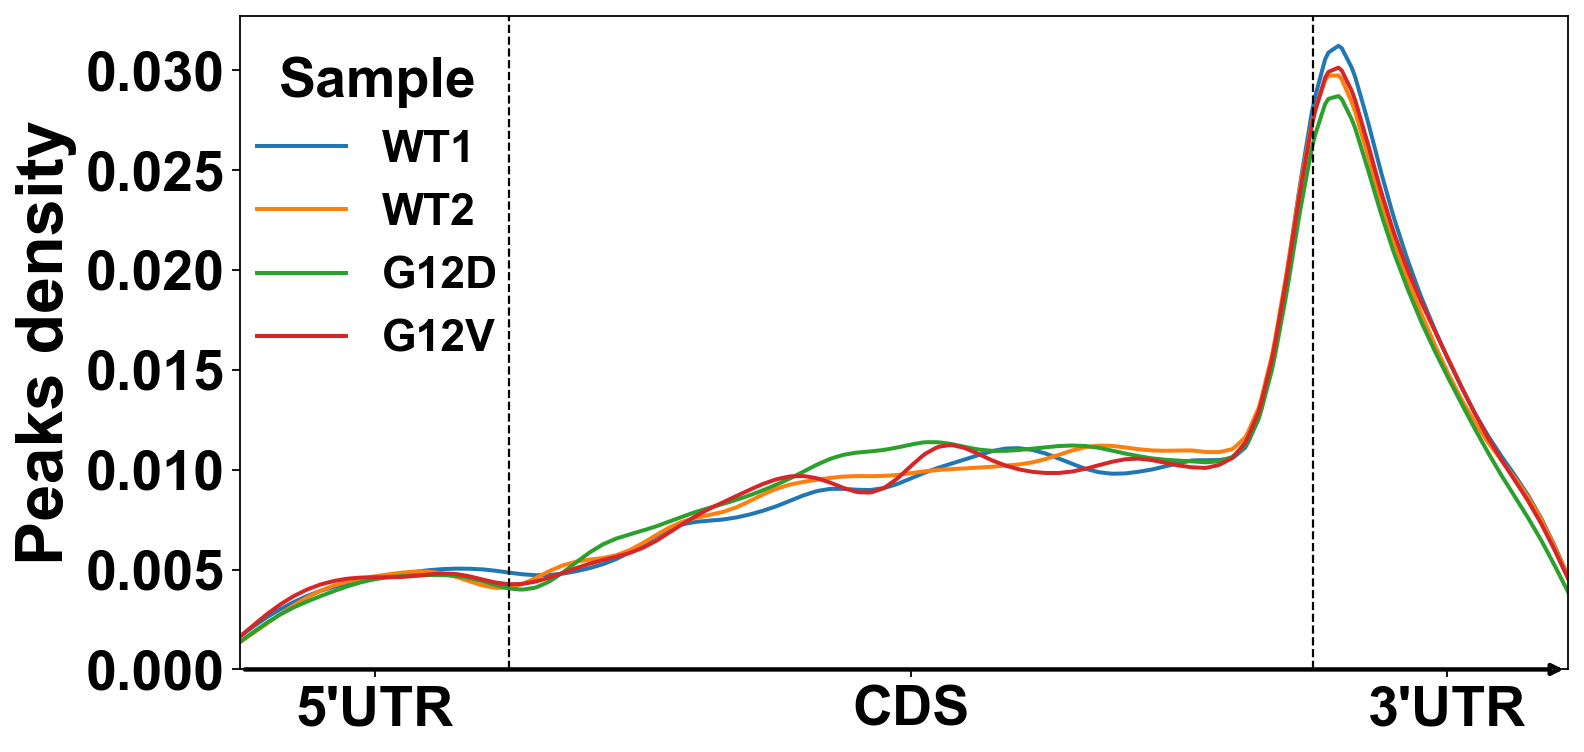

CPU times: user 1min 47s, sys: 6.51 s, total: 1min 53s
Wall time: 1min 48s


In [7]:
%%time
i = 0
if __name__ == '__main__':
    features_parquet = 'features.parquet'  
    features = load_features(features_parquet)

    beds = {
        'WT1' : path1 + sample[i] + '_0.05/Mod.bed',
        'WT2' : path1 + sample[i+1] + '_0.05/Mod.bed',
        'G12D' : path1 + sample[i+2] + '_0.05/Mod.bed',
        'G12V' : path1 + sample[i+3] + '_0.05/Mod.bed',
    }
    bed_points = load_beds(beds, usecols=(0,1,2,5))

    dens, total_bins = metaplot_counts(
        features,
        bed_points,
        bins_utr5=bins_utr5,
        bins_cds=bins_cds,
        bins_utr3=bins_utr3,
        respect_peak_strand=respect_peak_strand,
        smooth_sigma=smooth_sigma,
        upsample_factor=upsample_factor
    )
    plot_guitar_density(
        dens,
        bins_utr5=bins_utr5,
        bins_cds=bins_cds,
        bins_utr3=bins_utr3,
        title = None,
        groups_order=list(beds.keys())
    )